<a href="https://colab.research.google.com/github/nerdyvyoma136/Classifying-Malicious-Websites/blob/main/DAV_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Title: Classifying Malicious websites
## Group No. 27
## Supan Shah - AU2044011
## Vyoma Patel - AU2044005

# Importing necessary Libraries

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score, classification_report

# Importing Data

## Description of Dataset

Dataset: https://www.kaggle.com/xwolf12/malicious-and-benign-websites

The data uses three black lists to fetch malicious URLs:
* machinelearning.inginf.units.it/data-andtools/hidden-fraudulent-urls-dataset
* malwaredomainlist.com
* zeuztacker.abuse.ch

The benign URLs (345000) are from https://github.com/faizann24/Using-machinelearning-to-detect-malicious-URLs.git.

## Mounting dataset into colab

In [ ]:
import os
from google.colab import drive
drive.mount('/content/gdrive')
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
%cd /content/gdrive/My Drive/Kaggle
# !kaggle datasets download -d xwolf12/malicious-and-benign-websites
# !unzip \*.zip  && rm *.zip

Mounted at /content/gdrive
/content/gdrive/My Drive/Kaggle


## Loading the data as a DataFrame

In [ ]:
data = pd.read_csv('./dataset.csv')
data.head()

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
0,M0_109,16,7,iso-8859-1,nginx,263.0,None,None,10/10/2015 18:21,None,7,0,2,700,9,10,1153,832,9,2.0,1
1,B0_2314,16,6,UTF-8,Apache/2.4.10,15087.0,None,None,None,None,17,7,4,1230,17,19,1265,1230,17,0.0,0
2,B0_911,16,6,us-ascii,Microsoft-HTTPAPI/2.0,324.0,None,None,None,None,0,0,0,0,0,0,0,0,0,0.0,0
3,B0_113,17,6,ISO-8859-1,nginx,162.0,US,AK,7/10/1997 4:00,12/09/2013 0:45,31,22,3,3812,39,37,18784,4380,39,8.0,0
4,B0_403,17,6,UTF-8,None,124140.0,US,TX,12/05/1996 0:00,11/04/2017 0:00,57,2,5,4278,61,62,129889,4586,61,4.0,0


# Preprocessing

In [ ]:
data.describe(include='all')

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
count,1781,1781.000000,1781.000000,1781,1780,969.000000,1781,1781,1781,1781,1781.000000,1781.000000,1781.000000,1.781000e+03,1781.000000,1781.000000,1.781000e+03,1.781000e+03,1781.000000,1780.000000,1781.000000
unique,1781,NaN,NaN,9,239,NaN,49,182,891,594,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,B0_577,NaN,NaN,UTF-8,Apache,NaN,US,CA,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,676,386,NaN,1103,372,127,139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,56.961258,11.111735,NaN,NaN,11726.927761,NaN,NaN,NaN,NaN,16.261089,5.472768,3.060640,2.982339e+03,18.540146,18.746210,1.589255e+04,3.155599e+03,18.540146,2.263483,0.121280
std,NaN,27.555586,4.549896,NaN,NaN,36391.809051,NaN,NaN,NaN,NaN,40.500975,21.807327,3.386975,5.605057e+04,41.627173,46.397969,6.986193e+04,5.605378e+04,41.627173,2.930853,0.326544
min,NaN,16.000000,5.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
25%,NaN,39.000000,8.000000,NaN,NaN,324.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
50%,NaN,49.000000,10.000000,NaN,NaN,1853.000000,NaN,NaN,NaN,NaN,7.000000,0.000000,2.000000,6.720000e+02,8.000000,9.000000,5.790000e+02,7.350000e+02,8.000000,0.000000,0.000000
75%,NaN,68.000000,13.000000,NaN,NaN,11323.000000,NaN,NaN,NaN,NaN,22.000000,5.000000,5.000000,2.328000e+03,26.000000,25.000000,9.806000e+03,2.701000e+03,26.000000,4.000000,0.000000


From the above description of the data, we infer that:


1.   URL column is 100% unique -- GREAT !
2.   WHOIS_REGDATE (50% unique) and WHOIS_UPDATED_DATE (33% unique)
     have less unique values and doesn't affect our classification goal.

So, we can drop those two columns.



## Dropping Unwanted Columns

In [ ]:
data = data.drop(labels=['URL','WHOIS_REGDATE','WHOIS_UPDATED_DATE'], axis='columns')

Now let's check for null values (if existing)..

## Rectifying Null instances

In [ ]:
print(data.isnull().sum())

URL_LENGTH                     0
NUMBER_SPECIAL_CHARACTERS      0
CHARSET                        0
SERVER                         1
CONTENT_LENGTH               812
WHOIS_COUNTRY                  0
WHOIS_STATEPRO                 0
TCP_CONVERSATION_EXCHANGE      0
DIST_REMOTE_TCP_PORT           0
REMOTE_IPS                     0
APP_BYTES                      0
SOURCE_APP_PACKETS             0
REMOTE_APP_PACKETS             0
SOURCE_APP_BYTES               0
REMOTE_APP_BYTES               0
APP_PACKETS                    0
DNS_QUERY_TIMES                1
Type                           0
dtype: int64


Well, we can use interpolation to fill in the missing values.

### Interpolation to fill null values

In [ ]:
processed_data =  data.interpolate()
print(processed_data.isnull().sum())

URL_LENGTH                   0
NUMBER_SPECIAL_CHARACTERS    0
CHARSET                      0
SERVER                       1
CONTENT_LENGTH               0
WHOIS_COUNTRY                0
WHOIS_STATEPRO               0
TCP_CONVERSATION_EXCHANGE    0
DIST_REMOTE_TCP_PORT         0
REMOTE_IPS                   0
APP_BYTES                    0
SOURCE_APP_PACKETS           0
REMOTE_APP_PACKETS           0
SOURCE_APP_BYTES             0
REMOTE_APP_BYTES             0
APP_PACKETS                  0
DNS_QUERY_TIMES              0
Type                         0
dtype: int64


We see that now we just have 1 missing value (Server being 'None')

We can fill those values with the most frequent Server value

### Imputing most frequent Server value for categorical 'None' values

In [ ]:
len(processed_data[processed_data['SERVER'] =='None'])

175

In [ ]:
max_value = processed_data['SERVER'].value_counts().idxmax()

print('Highest frequency value:',max_value)

processed_data['SERVER'].fillna(max_value, inplace=True)

print(processed_data.isnull().sum())

Highest frequency value: Apache
URL_LENGTH                   0
NUMBER_SPECIAL_CHARACTERS    0
CHARSET                      0
SERVER                       0
CONTENT_LENGTH               0
WHOIS_COUNTRY                0
WHOIS_STATEPRO               0
TCP_CONVERSATION_EXCHANGE    0
DIST_REMOTE_TCP_PORT         0
REMOTE_IPS                   0
APP_BYTES                    0
SOURCE_APP_PACKETS           0
REMOTE_APP_PACKETS           0
SOURCE_APP_BYTES             0
REMOTE_APP_BYTES             0
APP_PACKETS                  0
DNS_QUERY_TIMES              0
Type                         0
dtype: int64


Preprocessing Done!!

# kNN

Before applying the model, we need to convert the categorical variables to indicator variables. We can do that simply by using pandas' get_dummies method as follows.

In [ ]:
knn_data = pd.get_dummies(processed_data)
knn_data.head()

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CONTENT_LENGTH,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type,CHARSET_ISO-8859,CHARSET_ISO-8859-1,CHARSET_None,CHARSET_UTF-8,CHARSET_iso-8859-1,CHARSET_us-ascii,CHARSET_utf-8,CHARSET_windows-1251,CHARSET_windows-1252,SERVER_.V01 Apache,SERVER_294,SERVER_ATS,SERVER_ATS/5.3.0,SERVER_Aeria Games & Entertainment,SERVER_AkamaiGHost,SERVER_AmazonS3,SERVER_Apache,SERVER_Apache-Coyote/1.1,SERVER_Apache/1.3.27 (Unix) (Red-Hat/Linux) mod_perl/1.26 PHP/4.3.3 FrontPage/5.0.2 mod_ssl/2.8.12 OpenSSL/0.9.6b,SERVER_Apache/1.3.27 (Unix) PHP/4.4.1,SERVER_Apache/1.3.31 (Unix) PHP/4.3.9 mod_perl/1.29 rus/PL30.20,SERVER_Apache/1.3.33 (Unix) mod_ssl/2.8.24 OpenSSL/0.9.7e-p1 PHP/4.4.8,SERVER_Apache/1.3.34 (Unix) PHP/4.4.4,SERVER_Apache/1.3.37 (Unix) mod_perl/1.29 mod_ssl/2.8.28 OpenSSL/0.9.7e-p1,SERVER_Apache/1.3.39 (Unix) PHP/5.2.5 mod_auth_passthrough/1.8 mod_bwlimited/1.4 mod_log_bytes/1.2 mod_gzip/1.3.26.1a FrontPage/5.0.2.2635 DAV/1.0.3 mod_ssl/2.8.30 OpenSSL/0.9.7a,SERVER_Apache/1.3.42 Ben-SSL/1.60 (Unix) mod_gzip/1.3.26.1a mod_fastcgi/2.4.6 mod_throttle/3.1.2 Chili!Soft-ASP/3.6.2 FrontPage/5.0.2.2635 mod_perl/1.31 PHP/4.4.9,...,WHOIS_STATEPRO_UK,WHOIS_STATEPRO_UT,WHOIS_STATEPRO_UTAH,WHOIS_STATEPRO_UTTAR PRADESH,WHOIS_STATEPRO_Utah,WHOIS_STATEPRO_Utr,WHOIS_STATEPRO_VA,WHOIS_STATEPRO_VERMONT,WHOIS_STATEPRO_VIC,WHOIS_STATEPRO_VT,WHOIS_STATEPRO_Vi,WHOIS_STATEPRO_Vic,WHOIS_STATEPRO_Virginia,WHOIS_STATEPRO_WA,WHOIS_STATEPRO_WC1N,WHOIS_STATEPRO_WEST MIDLANDS,WHOIS_STATEPRO_WI,WHOIS_STATEPRO_WV,WHOIS_STATEPRO_Washington,WHOIS_STATEPRO_Wisconsin,WHOIS_STATEPRO_ZH,WHOIS_STATEPRO_Zhejiang,WHOIS_STATEPRO_Zug,WHOIS_STATEPRO_ab,WHOIS_STATEPRO_bangkok,WHOIS_STATEPRO_bc,WHOIS_STATEPRO_beijingshi,WHOIS_STATEPRO_ca,WHOIS_STATEPRO_hunansheng,WHOIS_STATEPRO_il,WHOIS_STATEPRO_kireka,WHOIS_STATEPRO_liaoningsheng,WHOIS_STATEPRO_nj,WHOIS_STATEPRO_ny,WHOIS_STATEPRO_qc,WHOIS_STATEPRO_quebec,WHOIS_STATEPRO_shandong,WHOIS_STATEPRO_va,WHOIS_STATEPRO_widestep@mail.ru,WHOIS_STATEPRO_worcs
0,16,7,263.0,7,0,2,700,9,10,1153,832,9,2.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,16,6,15087.0,17,7,4,1230,17,19,1265,1230,17,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,16,6,324.0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,17,6,162.0,31,22,3,3812,39,37,18784,4380,39,8.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,17,6,124140.0,57,2,5,4278,61,62,129889,4586,61,4.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
X = knn_data.drop(labels='Type', axis='columns')
y = knn_data['Type']
X.head()

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CONTENT_LENGTH,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,CHARSET_ISO-8859,CHARSET_ISO-8859-1,CHARSET_None,CHARSET_UTF-8,CHARSET_iso-8859-1,CHARSET_us-ascii,CHARSET_utf-8,CHARSET_windows-1251,CHARSET_windows-1252,SERVER_.V01 Apache,SERVER_294,SERVER_ATS,SERVER_ATS/5.3.0,SERVER_Aeria Games & Entertainment,SERVER_AkamaiGHost,SERVER_AmazonS3,SERVER_Apache,SERVER_Apache-Coyote/1.1,SERVER_Apache/1.3.27 (Unix) (Red-Hat/Linux) mod_perl/1.26 PHP/4.3.3 FrontPage/5.0.2 mod_ssl/2.8.12 OpenSSL/0.9.6b,SERVER_Apache/1.3.27 (Unix) PHP/4.4.1,SERVER_Apache/1.3.31 (Unix) PHP/4.3.9 mod_perl/1.29 rus/PL30.20,SERVER_Apache/1.3.33 (Unix) mod_ssl/2.8.24 OpenSSL/0.9.7e-p1 PHP/4.4.8,SERVER_Apache/1.3.34 (Unix) PHP/4.4.4,SERVER_Apache/1.3.37 (Unix) mod_perl/1.29 mod_ssl/2.8.28 OpenSSL/0.9.7e-p1,SERVER_Apache/1.3.39 (Unix) PHP/5.2.5 mod_auth_passthrough/1.8 mod_bwlimited/1.4 mod_log_bytes/1.2 mod_gzip/1.3.26.1a FrontPage/5.0.2.2635 DAV/1.0.3 mod_ssl/2.8.30 OpenSSL/0.9.7a,SERVER_Apache/1.3.42 Ben-SSL/1.60 (Unix) mod_gzip/1.3.26.1a mod_fastcgi/2.4.6 mod_throttle/3.1.2 Chili!Soft-ASP/3.6.2 FrontPage/5.0.2.2635 mod_perl/1.31 PHP/4.4.9,SERVER_Apache/2,...,WHOIS_STATEPRO_UK,WHOIS_STATEPRO_UT,WHOIS_STATEPRO_UTAH,WHOIS_STATEPRO_UTTAR PRADESH,WHOIS_STATEPRO_Utah,WHOIS_STATEPRO_Utr,WHOIS_STATEPRO_VA,WHOIS_STATEPRO_VERMONT,WHOIS_STATEPRO_VIC,WHOIS_STATEPRO_VT,WHOIS_STATEPRO_Vi,WHOIS_STATEPRO_Vic,WHOIS_STATEPRO_Virginia,WHOIS_STATEPRO_WA,WHOIS_STATEPRO_WC1N,WHOIS_STATEPRO_WEST MIDLANDS,WHOIS_STATEPRO_WI,WHOIS_STATEPRO_WV,WHOIS_STATEPRO_Washington,WHOIS_STATEPRO_Wisconsin,WHOIS_STATEPRO_ZH,WHOIS_STATEPRO_Zhejiang,WHOIS_STATEPRO_Zug,WHOIS_STATEPRO_ab,WHOIS_STATEPRO_bangkok,WHOIS_STATEPRO_bc,WHOIS_STATEPRO_beijingshi,WHOIS_STATEPRO_ca,WHOIS_STATEPRO_hunansheng,WHOIS_STATEPRO_il,WHOIS_STATEPRO_kireka,WHOIS_STATEPRO_liaoningsheng,WHOIS_STATEPRO_nj,WHOIS_STATEPRO_ny,WHOIS_STATEPRO_qc,WHOIS_STATEPRO_quebec,WHOIS_STATEPRO_shandong,WHOIS_STATEPRO_va,WHOIS_STATEPRO_widestep@mail.ru,WHOIS_STATEPRO_worcs
0,16,7,263.0,7,0,2,700,9,10,1153,832,9,2.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,16,6,15087.0,17,7,4,1230,17,19,1265,1230,17,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,16,6,324.0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,17,6,162.0,31,22,3,3812,39,37,18784,4380,39,8.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,17,6,124140.0,57,2,5,4278,61,62,129889,4586,61,4.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print("Training size: %d" % len(y_train))
print("Test size    : %d" % len(y_test))

Training size: 1246
Test size    : 535


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
k=10

clf = KNeighborsClassifier(n_neighbors=k, p=2, weights='distance')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Accuracy of %d NN: %.2f %%" % (k, 100 * accuracy_score(y_test.to_numpy(), y_pred)))
print('Classification Report:\n{}\n'.format(classification_report(y_test.to_numpy(),clf.predict(X_test))))

Accuracy of 10 NN: 91.96 %
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.96       480
           1       0.69      0.40      0.51        55

    accuracy                           0.92       535
   macro avg       0.81      0.69      0.73       535
weighted avg       0.91      0.92      0.91       535




# Naive Bayes

### Preparing Data

In [ ]:
nb_data = pd.get_dummies(processed_data)
nb_data.head()

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CONTENT_LENGTH,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type,CHARSET_ISO-8859,CHARSET_ISO-8859-1,CHARSET_None,CHARSET_UTF-8,CHARSET_iso-8859-1,CHARSET_us-ascii,CHARSET_utf-8,CHARSET_windows-1251,CHARSET_windows-1252,SERVER_.V01 Apache,SERVER_294,SERVER_ATS,SERVER_ATS/5.3.0,SERVER_Aeria Games & Entertainment,SERVER_AkamaiGHost,SERVER_AmazonS3,SERVER_Apache,SERVER_Apache-Coyote/1.1,SERVER_Apache/1.3.27 (Unix) (Red-Hat/Linux) mod_perl/1.26 PHP/4.3.3 FrontPage/5.0.2 mod_ssl/2.8.12 OpenSSL/0.9.6b,SERVER_Apache/1.3.27 (Unix) PHP/4.4.1,SERVER_Apache/1.3.31 (Unix) PHP/4.3.9 mod_perl/1.29 rus/PL30.20,SERVER_Apache/1.3.33 (Unix) mod_ssl/2.8.24 OpenSSL/0.9.7e-p1 PHP/4.4.8,SERVER_Apache/1.3.34 (Unix) PHP/4.4.4,SERVER_Apache/1.3.37 (Unix) mod_perl/1.29 mod_ssl/2.8.28 OpenSSL/0.9.7e-p1,SERVER_Apache/1.3.39 (Unix) PHP/5.2.5 mod_auth_passthrough/1.8 mod_bwlimited/1.4 mod_log_bytes/1.2 mod_gzip/1.3.26.1a FrontPage/5.0.2.2635 DAV/1.0.3 mod_ssl/2.8.30 OpenSSL/0.9.7a,SERVER_Apache/1.3.42 Ben-SSL/1.60 (Unix) mod_gzip/1.3.26.1a mod_fastcgi/2.4.6 mod_throttle/3.1.2 Chili!Soft-ASP/3.6.2 FrontPage/5.0.2.2635 mod_perl/1.31 PHP/4.4.9,...,WHOIS_STATEPRO_UK,WHOIS_STATEPRO_UT,WHOIS_STATEPRO_UTAH,WHOIS_STATEPRO_UTTAR PRADESH,WHOIS_STATEPRO_Utah,WHOIS_STATEPRO_Utr,WHOIS_STATEPRO_VA,WHOIS_STATEPRO_VERMONT,WHOIS_STATEPRO_VIC,WHOIS_STATEPRO_VT,WHOIS_STATEPRO_Vi,WHOIS_STATEPRO_Vic,WHOIS_STATEPRO_Virginia,WHOIS_STATEPRO_WA,WHOIS_STATEPRO_WC1N,WHOIS_STATEPRO_WEST MIDLANDS,WHOIS_STATEPRO_WI,WHOIS_STATEPRO_WV,WHOIS_STATEPRO_Washington,WHOIS_STATEPRO_Wisconsin,WHOIS_STATEPRO_ZH,WHOIS_STATEPRO_Zhejiang,WHOIS_STATEPRO_Zug,WHOIS_STATEPRO_ab,WHOIS_STATEPRO_bangkok,WHOIS_STATEPRO_bc,WHOIS_STATEPRO_beijingshi,WHOIS_STATEPRO_ca,WHOIS_STATEPRO_hunansheng,WHOIS_STATEPRO_il,WHOIS_STATEPRO_kireka,WHOIS_STATEPRO_liaoningsheng,WHOIS_STATEPRO_nj,WHOIS_STATEPRO_ny,WHOIS_STATEPRO_qc,WHOIS_STATEPRO_quebec,WHOIS_STATEPRO_shandong,WHOIS_STATEPRO_va,WHOIS_STATEPRO_widestep@mail.ru,WHOIS_STATEPRO_worcs
0,16,7,263.0,7,0,2,700,9,10,1153,832,9,2.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,16,6,15087.0,17,7,4,1230,17,19,1265,1230,17,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,16,6,324.0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,17,6,162.0,31,22,3,3812,39,37,18784,4380,39,8.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,17,6,124140.0,57,2,5,4278,61,62,129889,4586,61,4.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
X = nb_data.drop(labels='Type', axis='columns')
y = nb_data['Type']
X.head()

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CONTENT_LENGTH,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,CHARSET_ISO-8859,CHARSET_ISO-8859-1,CHARSET_None,CHARSET_UTF-8,CHARSET_iso-8859-1,CHARSET_us-ascii,CHARSET_utf-8,CHARSET_windows-1251,CHARSET_windows-1252,SERVER_.V01 Apache,SERVER_294,SERVER_ATS,SERVER_ATS/5.3.0,SERVER_Aeria Games & Entertainment,SERVER_AkamaiGHost,SERVER_AmazonS3,SERVER_Apache,SERVER_Apache-Coyote/1.1,SERVER_Apache/1.3.27 (Unix) (Red-Hat/Linux) mod_perl/1.26 PHP/4.3.3 FrontPage/5.0.2 mod_ssl/2.8.12 OpenSSL/0.9.6b,SERVER_Apache/1.3.27 (Unix) PHP/4.4.1,SERVER_Apache/1.3.31 (Unix) PHP/4.3.9 mod_perl/1.29 rus/PL30.20,SERVER_Apache/1.3.33 (Unix) mod_ssl/2.8.24 OpenSSL/0.9.7e-p1 PHP/4.4.8,SERVER_Apache/1.3.34 (Unix) PHP/4.4.4,SERVER_Apache/1.3.37 (Unix) mod_perl/1.29 mod_ssl/2.8.28 OpenSSL/0.9.7e-p1,SERVER_Apache/1.3.39 (Unix) PHP/5.2.5 mod_auth_passthrough/1.8 mod_bwlimited/1.4 mod_log_bytes/1.2 mod_gzip/1.3.26.1a FrontPage/5.0.2.2635 DAV/1.0.3 mod_ssl/2.8.30 OpenSSL/0.9.7a,SERVER_Apache/1.3.42 Ben-SSL/1.60 (Unix) mod_gzip/1.3.26.1a mod_fastcgi/2.4.6 mod_throttle/3.1.2 Chili!Soft-ASP/3.6.2 FrontPage/5.0.2.2635 mod_perl/1.31 PHP/4.4.9,SERVER_Apache/2,...,WHOIS_STATEPRO_UK,WHOIS_STATEPRO_UT,WHOIS_STATEPRO_UTAH,WHOIS_STATEPRO_UTTAR PRADESH,WHOIS_STATEPRO_Utah,WHOIS_STATEPRO_Utr,WHOIS_STATEPRO_VA,WHOIS_STATEPRO_VERMONT,WHOIS_STATEPRO_VIC,WHOIS_STATEPRO_VT,WHOIS_STATEPRO_Vi,WHOIS_STATEPRO_Vic,WHOIS_STATEPRO_Virginia,WHOIS_STATEPRO_WA,WHOIS_STATEPRO_WC1N,WHOIS_STATEPRO_WEST MIDLANDS,WHOIS_STATEPRO_WI,WHOIS_STATEPRO_WV,WHOIS_STATEPRO_Washington,WHOIS_STATEPRO_Wisconsin,WHOIS_STATEPRO_ZH,WHOIS_STATEPRO_Zhejiang,WHOIS_STATEPRO_Zug,WHOIS_STATEPRO_ab,WHOIS_STATEPRO_bangkok,WHOIS_STATEPRO_bc,WHOIS_STATEPRO_beijingshi,WHOIS_STATEPRO_ca,WHOIS_STATEPRO_hunansheng,WHOIS_STATEPRO_il,WHOIS_STATEPRO_kireka,WHOIS_STATEPRO_liaoningsheng,WHOIS_STATEPRO_nj,WHOIS_STATEPRO_ny,WHOIS_STATEPRO_qc,WHOIS_STATEPRO_quebec,WHOIS_STATEPRO_shandong,WHOIS_STATEPRO_va,WHOIS_STATEPRO_widestep@mail.ru,WHOIS_STATEPRO_worcs
0,16,7,263.0,7,0,2,700,9,10,1153,832,9,2.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,16,6,15087.0,17,7,4,1230,17,19,1265,1230,17,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,16,6,324.0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,17,6,162.0,31,22,3,3812,39,37,18784,4380,39,8.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,17,6,124140.0,57,2,5,4278,61,62,129889,4586,61,4.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(nb_data, y, test_size=0.3)

print("Training size: %d" % len(y_train))
print("Test size    : %d" % len(y_test))

Training size: 1246
Test size    : 535


## Gaussian Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
nb_clf= GaussianNB()
nb_clf.fit(X_train, y_train)

y_pred = nb_clf.predict(X_test)

print("Accuracy of GNB: %.2f %%" % ( 100 * accuracy_score(y_test.to_numpy(), y_pred)))
print('Classification Report:\n{}\n'.format(classification_report(y_test.to_numpy(),nb_clf.predict(X_test))))

Accuracy of GNB: 32.34 %
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.25      0.39       478
           1       0.13      0.96      0.23        57

    accuracy                           0.32       535
   macro avg       0.56      0.61      0.31       535
weighted avg       0.89      0.32      0.38       535




Very low F1

## Multinomial Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
nb_clf= MultinomialNB()
nb_clf.fit(X_train, y_train)

y_pred = nb_clf.predict(X_test)

print("Accuracy of MNB: %.2f %%" % ( 100 * accuracy_score(y_test.to_numpy(), y_pred)))
print('Classification Report:\n{}\n'.format(classification_report(y_test.to_numpy(),nb_clf.predict(X_test))))

Accuracy of MNB: 44.30 %
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.44      0.59       478
           1       0.09      0.46      0.15        57

    accuracy                           0.44       535
   macro avg       0.48      0.45      0.37       535
weighted avg       0.79      0.44      0.54       535




## Bernoulli Naive Bayes

In [ ]:
from sklearn.naive_bayes import BernoulliNB
nb_clf= BernoulliNB()
nb_clf.fit(X_train, y_train)

y_pred = nb_clf.predict(X_test)
print("Accuracy of BNB: %.2f %%" % ( 100 * accuracy_score(y_test.to_numpy(), y_pred)))
print('Classification Report:\n{}\n'.format(classification_report(y_test.to_numpy(),nb_clf.predict(X_test))))

Accuracy of BNB: 100.00 %
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       478
           1       1.00      1.00      1.00        57

    accuracy                           1.00       535
   macro avg       1.00      1.00      1.00       535
weighted avg       1.00      1.00      1.00       535




Near-perfect performance!!

## Multimodal Naive  Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
nb_clf= MultinomialNB()
nb_clf.fit(X_train, y_train)

y_pred = nb_clf.predict(X_test)
print("Accuracy of MNB: %.2f %%" % ( 100 * accuracy_score(y_test.to_numpy(), y_pred)))
print('Classification Report:\n{}\n'.format(classification_report(y_test.to_numpy(),nb_clf.predict(X_test))))

Accuracy of MNB: 44.30 %
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.44      0.59       478
           1       0.09      0.46      0.15        57

    accuracy                           0.44       535
   macro avg       0.48      0.45      0.37       535
weighted avg       0.79      0.44      0.54       535




# Comparing all the models at one go

KNN: 0.892185 (0.025756)
GNB: 0.268348 (0.038789)
MNB: 0.415498 (0.044027)
BNB: 0.885465 (0.023417)
KNNS: 0.938281 (0.042344)
GNBS: 0.617064 (0.047558)
MNBS: 0.908509 (0.042612)
BNBS: 0.886583 (0.022987)
Run times: [1.0815978050231934, 0.15343356132507324, 0.1504054069519043, 0.2180624008178711, 2.9593610763549805, 0.12293791770935059, 0.08051371574401855, 0.13460111618041992]


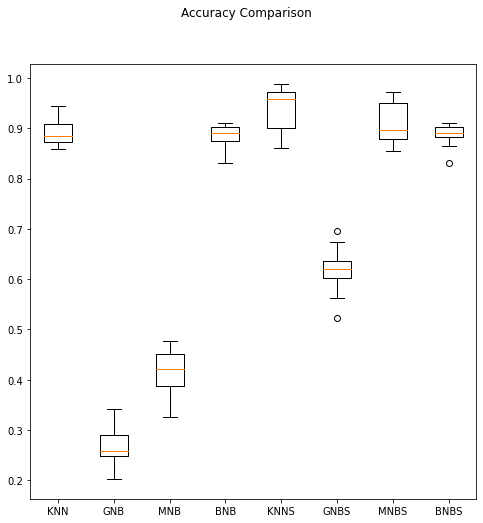

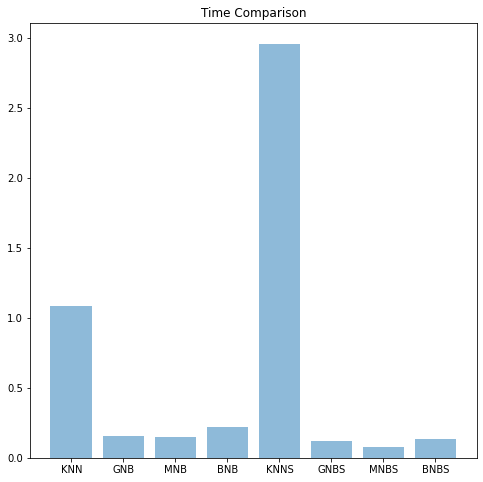

In [ ]:
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
models = []
models.append(('KNN', KNeighborsClassifier(n_neighbors=k, p=2, weights='distance'), 0))
models.append(('GNB', GaussianNB(), 0))
models.append(('MNB', MultinomialNB(), 0))
models.append(('BNB', BernoulliNB(), 0))
# models with normalization on numerical columns
models.append(('KNNS', KNeighborsClassifier(n_neighbors=k, p=2, weights='distance'), 1))
models.append(('GNBS', GaussianNB(), 1))
models.append(('MNBS', MultinomialNB(), 1))
models.append(('BNBS', BernoulliNB(), 1))

results = []
names = []
run_times = []
scoring = 'accuracy'
for name, model, scaler in models:
    start = time.time()
    kfold = KFold(n_splits=10)
    if(scaler==1):
        scaler = MinMaxScaler()
        scaled_X  = scaler.fit_transform(X)
        cv_results = cross_val_score(model, scaled_X, y, cv=10, scoring=scoring)
    else:
        cv_results = cross_val_score(model, X, y, cv=10, scoring=scoring)
    stop= time.time()
    run_times.append(stop-start)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    

print( "Run times: %s" % (run_times))
fig = plt.figure(figsize=(8, 8))
fig.suptitle('Accuracy Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()


y_pos = np.arange(len(names))
plt.figure(figsize=(8, 8))
plt.bar(y_pos, run_times, align='center', alpha=0.5)
plt.xticks(y_pos, names)
plt.title('Time Comparison')
plt.show()

# Conclusion

## Bernoulli Naive Bayes (with normalization) seems the best

Given the time taken and accuracy measures, the performance of Bernoulli Naive Bayes algorithm with normalized numerical features seems the best model at an accuracy measure of 99.63 %